# Binary VAE para Hash
### Francisco Mena
Basado en:
* https://github.com/EderSantana/gumbel/
* https://github.com/EmilienDupont/vae-concrete
---

> ## Binary Variational Semantic Hashing

---

Load libraries to use

In [1]:
import numpy as np
import keras,gc,nltk
from keras.layers import *
from keras.models import Sequential,Model
from keras import backend as K
from astropy.table import Table
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
nltk.download('reuters')
nltk.download('wordnet')
%matplotlib inline

from base_networks import *

Using TensorFlow backend.


[nltk_data] Downloading package reuters to /home/fmena/nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package wordnet to /home/fmena/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Load Data

### 20 Newsgroup
---

Citado por Semantic Hashing (http://people.csail.mit.edu/jrennie/20Newsgroups), también disponible en **sklearn**. El dataset contiene textos de usuarios asociados a temáticas de noticias etiquetados como pertenenciente a uno de 20 grupos de noticias, el detalle de los conjuntos se detalla a continuación:

|Tipo set|Datos|
|---|---|
|Entrenamiento|11.314|
|Pruebas|7.532|

In [2]:
from sklearn.datasets import fetch_20newsgroups
newsgroups_t = fetch_20newsgroups(subset='train')
newsgroups_test = fetch_20newsgroups(subset='test')
labels = newsgroups_t.target_names

texts_t = newsgroups_t.data
y_t = newsgroups_t.target
labels_t = [labels[valor] for valor in y_t]

texts_test = newsgroups_test.data
y_test = newsgroups_test.target
labels_test = [labels[valor] for valor in y_test]

print("Datos de entrenamiento: ",y_t.shape)
print("Datos de prueba: ",y_test.shape)

Datos de entrenamiento:  (11314,)
Datos de prueba:  (7532,)


In [6]:
labels

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

Anteriormente se presentan los 20 posibles grupos de las noticias, algunos ejemplos de texto se muestran a continuacion:

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----







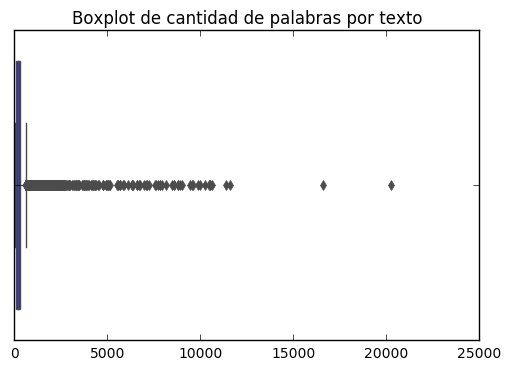

In [108]:
print(texts_t[0])
sns.boxplot(list(map(len,[texto.split(' ') for texto in texts_t])))
plt.title("Boxplot de cantidad de palabras por texto")
plt.show()

Es el dataset con los documentos más extensos en información o textos.

### Reuters21578
---
Similar a 20NewsGroup es un datataset de textos de noticias del periodico de Reuters en 1987, citado en papers (https://www.nltk.org/book/ch02.html) y disponible en la librería **nltk**. El detalle de los conjuntos se muestra a continuación:

|Tipo set|Datos|
|---|---|
|Entrenamiento|7.769|
|Pruebas|3.019|

Los documentos pueden pertenecer a **múltiples tópicos** dentro de 90 disponibles en el dataset manualmente etiquetadas, ésto es porque un texto asociado a una noticia puede hablar de varios tópicos a la vez. 

In [28]:
from nltk.corpus import reuters
documents_stat = reuters.fileids()
print(str(len(documents_stat)) + " documents")

train_docs_stat = list(filter(lambda doc: doc.startswith("train"), documents_stat))
print(str(len(train_docs_stat)) + " total training documents")
test_docs_stat = list(filter(lambda doc: doc.startswith("test"), documents_stat))
print(str(len(test_docs_stat)) + " total test documents")

texts_t = [reuters.raw(archivo) for archivo in train_docs_stat]
labels_t = [reuters.categories(archivo) for archivo in train_docs_stat]

texts_test = [reuters.raw(archivo) for archivo in test_docs_stat]
labels_test = [reuters.categories(archivo) for archivo in test_docs_stat]

10788 documents
7769 total training documents
3019 total test documents


In [29]:
labels = reuters.categories()
labels

['acq',
 'alum',
 'barley',
 'bop',
 'carcass',
 'castor-oil',
 'cocoa',
 'coconut',
 'coconut-oil',
 'coffee',
 'copper',
 'copra-cake',
 'corn',
 'cotton',
 'cotton-oil',
 'cpi',
 'cpu',
 'crude',
 'dfl',
 'dlr',
 'dmk',
 'earn',
 'fuel',
 'gas',
 'gnp',
 'gold',
 'grain',
 'groundnut',
 'groundnut-oil',
 'heat',
 'hog',
 'housing',
 'income',
 'instal-debt',
 'interest',
 'ipi',
 'iron-steel',
 'jet',
 'jobs',
 'l-cattle',
 'lead',
 'lei',
 'lin-oil',
 'livestock',
 'lumber',
 'meal-feed',
 'money-fx',
 'money-supply',
 'naphtha',
 'nat-gas',
 'nickel',
 'nkr',
 'nzdlr',
 'oat',
 'oilseed',
 'orange',
 'palladium',
 'palm-oil',
 'palmkernel',
 'pet-chem',
 'platinum',
 'potato',
 'propane',
 'rand',
 'rape-oil',
 'rapeseed',
 'reserves',
 'retail',
 'rice',
 'rubber',
 'rye',
 'ship',
 'silver',
 'sorghum',
 'soy-meal',
 'soy-oil',
 'soybean',
 'strategic-metal',
 'sugar',
 'sun-meal',
 'sun-oil',
 'sunseed',
 'tea',
 'tin',
 'trade',
 'veg-oil',
 'wheat',
 'wpi',
 'yen',
 'zinc']

BAHIA COCOA REVIEW
  Showers continued throughout the week in
  the Bahia cocoa zone, alleviating the drought since early
  January and improving prospects for the coming temporao,
  although normal humidity levels have not been restored,
  Comissaria Smith said in its weekly review.
      The dry period means the temporao will be late this year.
      Arrivals for the week ended February 22 were 155,221 bags
  of 60 kilos making a cumulative total for the season of 5.93
  mln against 5.81 at the same stage last year. Again it seems
  that cocoa delivered earlier on consignment was included in the
  arrivals figures.
      Comissaria Smith said there is still some doubt as to how
  much old crop cocoa is still available as harvesting has
  practically come to an end. With total Bahia crop estimates
  around 6.4 mln bags and sales standing at almost 6.2 mln there
  are a few hundred thousand bags still in the hands of farmers,
  middlemen, exporters and processors.
      There are doubt

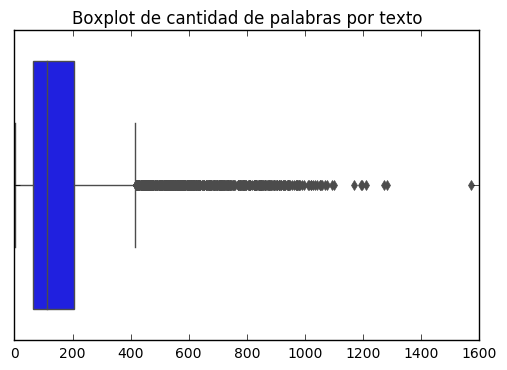

In [110]:
print(texts_t[0])

sns.boxplot(list(map(len,[texto.split(' ') for texto in texts_t])))
plt.title("Boxplot de cantidad de palabras por texto")
plt.show()

In [47]:
#borrar para presentacion
labels_t[:10]

[['cocoa'],
 ['acq'],
 ['money-supply'],
 ['acq'],
 ['earn'],
 ['earn'],
 ['acq', 'trade'],
 ['earn'],
 ['crude', 'nat-gas'],
 ['cocoa', 'coffee', 'sugar']]

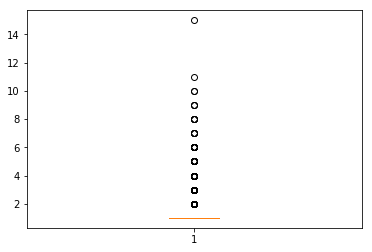

In [77]:
plt.boxplot(list(map(len,labels_t)))
plt.show()

El dataset anterior también es extenso en sus documentos pero no tan extremo como 20 Newsgroup.

### SearchSnipet
---
Dataset de Google search *snippets*-- pequeñas porciones de texto que le dan a usuarios una idea de lo que hay en el sitio web. Pertenecientes a 8 clases únicas (dominio). Disponibles a través de http://jwebpro.sourceforge.net/data-web-snippets.tar.gz.


|Tipo set|Datos|
|---|---|
|Entrenamiento|10.060|
|Pruebas|2.280|

In [48]:
def read_file(archivo,symb=' '):
    with open(archivo,'r') as f:
        lineas = f.readlines()
        tokens_f = [linea.strip().split(symb) for linea in lineas]
        labels = [tokens[-1] for tokens in tokens_f]
        tokens = [' '.join(tokens[:-1]) for tokens in tokens_f]
    return labels,tokens
labels_t,texts_t = read_file("Data/data-web-snippets/train.txt")
labels_test,texts_test = read_file("Data/data-web-snippets/test.txt")
print("Datos de entrenamiento: ",len(texts_t))
print("Datos de pruebas: ",len(texts_test))

Datos de entrenamiento:  10060
Datos de pruebas:  2280


In [49]:
labels = list(set(labels_t))
labels

['computers',
 'culture-arts-entertainment',
 'politics-society',
 'sports',
 'engineering',
 'education-science',
 'business',
 'health']

europa enterprise pharmaceuticals eudralex homev eudralex volume medicinal products human veterinary annex manufacture biological medicinal products human annex manufacture products human blood human plasma


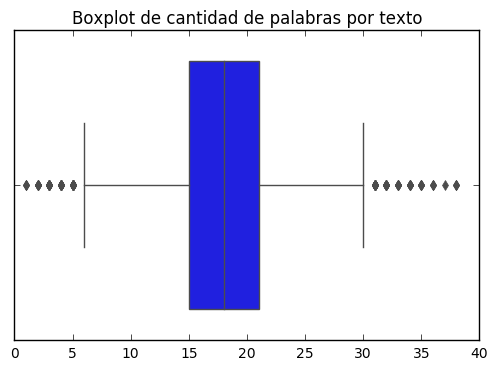

In [112]:
print(texts_t[10])

sns.boxplot(list(map(len,[texto.split(' ') for texto in texts_t])))
plt.title("Boxplot de cantidad de palabras por texto")
plt.show()

### Reuters Corpus Volume 1
---
Corpus de Reuters extendido, con los 103 tópicos originales. Disponible en trabajos previos (https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/multilabel.html) y a través de **sklearn** (#https://scikit-learn.org/0.17/datasets/rcv1.html).


La representación son las *features* ya extraídas.

Probar este una vez ya experimentado con los pequeños anteriores


In [63]:
from sklearn.datasets import fetch_rcv1
rcv1_train = fetch_rcv1(subset='train')
rcv1_test = fetch_rcv1(subset='test')
X_train = rcv1_train.data
y_train = rcv1_train.target
X_test = rcv1_test.data
y_test = rcv1_test.target

X_train

<23149x47236 sparse matrix of type '<class 'numpy.float64'>'
	with 1757801 stored elements in Compressed Sparse Row format>

In [11]:
X_train.shape

(23149, 47236)

In [13]:
y_test.shape

(781265, 103)

In [15]:
rcv1_train.target_names

array(['C11', 'C12', 'C13', 'C14', 'C15', 'C151', 'C1511', 'C152', 'C16',
       'C17', 'C171', 'C172', 'C173', 'C174', 'C18', 'C181', 'C182',
       'C183', 'C21', 'C22', 'C23', 'C24', 'C31', 'C311', 'C312', 'C313',
       'C32', 'C33', 'C331', 'C34', 'C41', 'C411', 'C42', 'CCAT', 'E11',
       'E12', 'E121', 'E13', 'E131', 'E132', 'E14', 'E141', 'E142',
       'E143', 'E21', 'E211', 'E212', 'E31', 'E311', 'E312', 'E313',
       'E41', 'E411', 'E51', 'E511', 'E512', 'E513', 'E61', 'E71', 'ECAT',
       'G15', 'G151', 'G152', 'G153', 'G154', 'G155', 'G156', 'G157',
       'G158', 'G159', 'GCAT', 'GCRIM', 'GDEF', 'GDIP', 'GDIS', 'GENT',
       'GENV', 'GFAS', 'GHEA', 'GJOB', 'GMIL', 'GOBIT', 'GODD', 'GPOL',
       'GPRO', 'GREL', 'GSCI', 'GSPO', 'GTOUR', 'GVIO', 'GVOTE', 'GWEA',
       'GWELF', 'M11', 'M12', 'M13', 'M131', 'M132', 'M14', 'M141',
       'M142', 'M143', 'MCAT'], dtype=object)

### Validation creation

In [50]:
from sklearn.model_selection import train_test_split
labels_t = np.asarray(labels_t)
labels_test = np.asarray(labels_test)
texts_train,texts_val,labels_train,labels_val  = train_test_split(texts_t,labels_t,random_state=20,test_size=0.25)
print("Cantidad de datos Entrenamiento: ",len(texts_train))
print("Cantidad de datos Validación: ",len(texts_val))
print("Cantidad de datos Pruebas: ",len(texts_test))

Cantidad de datos Entrenamiento:  7545
Cantidad de datos Validación:  2515
Cantidad de datos Pruebas:  2280


## Pre-process
---
Obtain the data representation


paper Variational Deep Semantic Hashing:
> "*Each dataset was split into three subsets with roughly 80% for training, 10% for validation, and 10% for test. The training data is used to learn the mapping from document to hash code. Each document in the test set is used to retrieve similar documents based on the mapping, and the results are evaluated. The validation set is used to choose the hyperparameters. We removed the stopwords using SMART’s list of 571 stopwords 5 . No stemming was performed. We use TFIDF [23] as the default term weighting scheme for the raw document representation (i.e., d). We experiment with other term weighting schemes in Section 5.4.*"

REvisar si este paper hace algo con la cantidad de features

Hinton: 
> "*We further preprocessed the data by removing common stopwords, stemming, and then only considering the 2000 most frequent words in the training dataset. As a result, each posting was represented as a vector containing 2000 word counts. No other preprocessing was done.*"



* Stemmed version (citado en 2 trabajos) -> http://web.ist.utl.pt/acardoso/datasets/  


Se experimenta con dos tipos de pre-procesamiento:

1. El primero es el siguiente: 
    * Pasar letras a minúsculas
    * Eliminar extra espacios (saltos de línea por ejemplo)
    * Remover stop words
    * Borrar todo lo que no sea letras (eliminar números y puntuaciones)
    * Conservar las top $k$ palabras/*tokens* más frecuentes
2. El segundo añade lo siguiente:
    * Se realiza un *stemming* (Snowball) -- Lemmatization
    * Remover palabras de menos de 3 largo



Para la representación se utiliza lo siguiente:
* TF-IDF: 
$$ w_f(d) \cdot \left(1 + log\left( \frac{1+n_d}{1+df_w} \right) \right)$$
* **TF (*term frecuency*)**: $$ w_f(d) $$
* Binary: $$I(w_f(d) \neq 0)$$

In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer 
analyzer = TfidfVectorizer().build_analyzer()
stemmer = SnowballStemmer("english") 
lemmatizer = WordNetLemmatizer()

"""Extract features from raw input"""
def preProcess(s): #String processor
    return s.lower().strip().strip('-').strip('_')
def number_normalize(doc):
    results = []
    for token in analyzer(doc):
        token_pro = preProcess(token)
        if len(token_pro) != 0 and not token_pro[0].isdigit():
            results.append(token_pro)
    return results
def stemmed_words(doc):
    results = []
    for token in analyzer(doc):
        pre_pro = preProcess(token)
        #token_pro = stemmer.stem(pre_pro) #aumenta x10 el tiempo de procesamiento
        token_pro = lemmatizer.lemmatize(pre_pro) #so can explain/interpretae -- aumenta x5 el tiempo de proce
        if len(token_pro) > 2 and not token_pro[0].isdigit(): #elimina palabra largo menor a 2
            results.append(token_pro)
    return results

def get_transform_representation(mode, analizer,min_count,max_feat):
    #default is tf
    smooth_idf_b = False
    use_idf_b = False
    binary_b = False

    if mode == 'binary':
        binary_b = True
    elif mode == 'tf':
        pass
    elif mode == 'tf-idf':
        use_idf_b = True
        smooth_idf_b = True #inventa 1 conteo imaginario (como priors)--laplace smoothing
    return TfidfVectorizer(stop_words='english',analyzer=analizer,min_df=min_count, max_features=max_feat
                                ,binary=binary_b, use_idf=use_idf_b, smooth_idf=smooth_idf_b,norm=None) 

min_count = 1 #default = 1
max_feat = 10000 #Best: 10000 -- Hinton (2000)


vectorizer = get_transform_representation("tf", stemmed_words,min_count,max_feat)

%time vectorizer.fit(texts_train)
vectors_train = vectorizer.transform(texts_train)
vectors_val = vectorizer.transform(texts_val)
vectors_test = vectorizer.transform(texts_test)

vectorizer2 = get_transform_representation("tf-idf", stemmed_words,min_count,max_feat)

%time vectorizer2.fit(texts_train)
vectors_train2 = vectorizer2.transform(texts_train)
vectors_val2 = vectorizer2.transform(texts_val)
vectors_test2 = vectorizer2.transform(texts_test)
vectors_train.shape

CPU times: user 619 ms, sys: 516 µs, total: 620 ms
Wall time: 615 ms
CPU times: user 609 ms, sys: 0 ns, total: 609 ms
Wall time: 607 ms


(7545, 10000)

En la celda anterior se calculan dos representaciones deseables de los datos, *term frequency* y *tf-idf*. A continuación se muestra cómo quedó el vocabulario.

In [52]:
token2idx = vectorizer.vocabulary_
idx2token = {idx:token for token,idx in token2idx.items()}
idx2token

{0: 'aaa',
 1: 'aaai',
 2: 'aaamc',
 3: 'aaaoeuh',
 4: 'aabt',
 5: 'aac',
 6: 'aacarsgasa',
 7: 'aacc',
 8: 'aacrjournals',
 9: 'aad',
 10: 'aae',
 11: 'aamc',
 12: 'aamft',
 13: 'aapl',
 14: 'aardvark',
 15: 'aaron',
 16: 'aaronsw',
 17: 'aarp',
 18: 'aarweb',
 19: 'aasqw',
 20: 'aaup',
 21: 'aavoda',
 22: 'aawd',
 23: 'aba',
 24: 'abanet',
 25: 'abbr',
 26: 'abbreviated',
 27: 'abbreviation',
 28: 'abc',
 29: 'abcnews',
 30: 'abct',
 31: 'abdominal',
 32: 'abell',
 33: 'aberdeen',
 34: 'ability',
 35: 'aboard',
 36: 'abortion',
 37: 'about',
 38: 'aboutcern',
 39: 'aboutme',
 40: 'aboutpublicrelations',
 41: 'aboutus',
 42: 'abp',
 43: 'abreast',
 44: 'abridged',
 45: 'abroad',
 46: 'abrs',
 47: 'abrupt',
 48: 'absolute',
 49: 'absolutely',
 50: 'absorbed',
 51: 'absorption',
 52: 'abstract',
 53: 'abstraction',
 54: 'abstractism',
 55: 'abt',
 56: 'abuse',
 57: 'abused',
 58: 'abyss',
 59: 'acad',
 60: 'academia',
 61: 'academic',
 62: 'academicinfo',
 63: 'academy',
 64: 'academyaw

In [53]:
#todense --get representation
X_train = np.asarray(vectors_train.todense())
X_val = np.asarray(vectors_val.todense())
X_test = np.asarray(vectors_test.todense())

X_train2 = np.asarray(vectors_train2.todense())
X_val2 = np.asarray(vectors_val2.todense())
X_test2 = np.asarray(vectors_test2.todense())

del vectors_train,vectors_val,vectors_test,vectors_train2,vectors_val2,vectors_test2
gc.collect()

X_train[0]

array([0., 0., 0., ..., 0., 0., 0.])

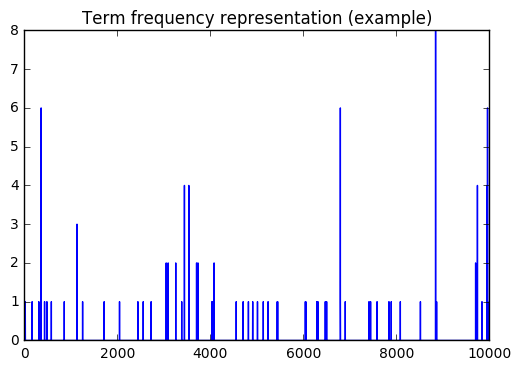

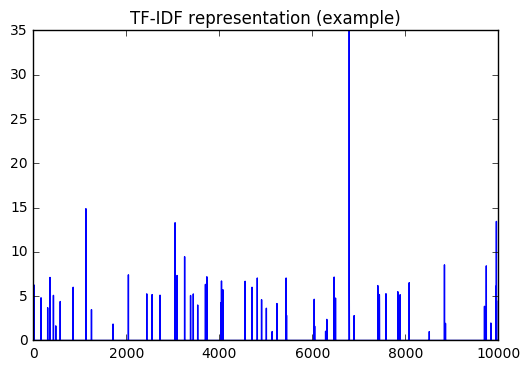

In [6]:
plt.title("Term frequency representation (example)")
plt.plot(X_train[0])
plt.show()

plt.title("TF-IDF representation (example)")
plt.plot(X_train2[0])
plt.show()

### Model Architecture
---
Basado en Variational Deep Semantic Hashing, una arquitectura de autoencoder no simétrico:

> Input(|V|) -> Relu(500) -> Relu (500) -> Laten variable(32) (8-128)*2 -> Sampling -> Softmax(|V|)

Dos capas escondidas en el *encoder* y sin capas escondidas en el *decoder*. Añadiendo una capa de *BatchNormalization* entre capas continuas.  

Tamién se experimenta con una arquitectura simétrica como se realiza en el trabajo de *Semantic Hashing*.

La primera experimentación se realiza con 32 *bits* en la representación latente, ya que los trabajos previos han mostrado que esta cantidad de *bits* parece ser lo suficiente antes de empezar a realizar *overfitting*.

In [7]:
def traditional_VAE(data_dim,Nb,units,layers_e,layers_d,opt='adam',BN=True):
    pre_encoder = define_pre_encoder(data_dim, layers=layers_e,units=units,BN=BN)
    print("pre-encoder network:")
    pre_encoder.summary()
    generator = define_generator(Nb,data_dim,layers=layers_d,units=units,BN=BN)
    print("generator network:")
    generator.summary()
    
    ## Encoder
    x = Input(shape=(data_dim,))
    hidden = pre_encoder(x)
    z_mean = Dense(Nb,activation='linear', name='z-mean')(hidden)
    z_log_var = Dense(Nb,activation='linear',name = 'z-log_var')(hidden)
    encoder = Model(x, z_mean) # build a model to project inputs on the latent space

    def sampling(args):
        epsilon_std = 1.0
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(K.shape(z_mean)[0], Nb),mean=0., stddev=epsilon_std)
        return z_mean + K.exp(0.5*z_log_var) * epsilon #+sigma (desvest)
    
    ## Decoder
    z_sampled = Lambda(sampling, output_shape=(Nb,), name='sampled')([z_mean, z_log_var])
    output = generator(z_sampled)

    def vae_loss(x, x_hat):
        reconstruction_loss = keras.losses.categorical_crossentropy(x, x_hat)*data_dim 
        #reconstruction_loss = keras.losses.binary_crossentropy(x, x_hat)*data_dim 

        kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) #con varianza
        return K.mean(reconstruction_loss  + kl_loss)

    traditional_vae = Model(x, output)
    traditional_vae.compile(optimizer=opt,loss=vae_loss)
    return traditional_vae,encoder,generator

traditional_vae,encoder_Tvae,generator_Tvae = traditional_VAE(X_train.shape[1],Nb=32,units=500,layers_e=2,layers_d=0)
traditional_vae.summary()

pre-encoder network:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 500)               5000500   
_________________________________________________________________
batch_normalization_1 (Batch (None, 500)               2000      
_________________________________________________________________
dense_2 (Dense)              (None, 500)               250500    
_________________________________________________________________
batch_normalization_2 (Batch (None, 500)               2000      
Total params: 5,255,000
Trainable params: 5,253,000
Non-trainable params: 2,000
_________________________________________________________________
generator network:
_________________________________________________________________
Layer (type)          

In [8]:
tau = K.variable(0.67, name="temperature") #o tau fijo en 0.67

anneal_rate = 0.003
min_temperature = 0.5
tau_ann = K.variable(5.0, name="temperature") #o tau fijo en 0.67

def sample_gumbel(shape,eps=K.epsilon()):
    """Inverse Sample function from Gumbel(0, 1)"""
    U = K.random_uniform(shape, 0, 1)
    return K.log(U + eps)- K.log(1-U + eps)

class My_Callback(keras.callbacks.Callback):    
    def on_epoch_end(self, epoch, logs={}):
        K.set_value(tau_ann, np.max([K.get_value(tau_ann) * np.exp(- anneal_rate * epoch), min_temperature])) 
        print(tau_ann.value().eval(session=keras.backend.get_session()))
        return

def binary_VAE(data_dim,Nb,units,layers_e,layers_d,opt='adam',BN=True):
    pre_encoder = define_pre_encoder(data_dim, layers=layers_e,units=units,BN=BN)
    print("pre-encoder network:")
    pre_encoder.summary()
    generator = define_generator(Nb,data_dim,layers=layers_d,units=units,BN=BN)
    print("generator network:")
    generator.summary()

    x = Input(shape=(data_dim,))
    hidden = pre_encoder(x)
    logits_b  = Dense(Nb, activation='linear', name='logits-b')(hidden) #log(p(b)/1-p(b))
    #proba = np.exp(logits_b)/(1+np.exp(logits_b)) = sigmoidal(logits_b) <<<<<<<<<< recuepra probabilidad
    #dist = Dense(Nb, activation='sigmoid')(hidden) #p(b) #otra forma de modelarlo
    encoder = Model(x, logits_b)

    def sampling(logits_b):
        #logits_b = K.log(aux/(1-aux) + K.epsilon() )
        b = logits_b + sample_gumbel(K.shape(logits_b)) # logits + gumbel noise
        return keras.activations.sigmoid( b/tau )

    b_sampled = Lambda(sampling, output_shape=(Nb,), name='sampled')(logits_b)
    output = generator(b_sampled)

    def gumbel_loss(x, x_hat):
        reconstruction_loss = keras.losses.categorical_crossentropy(x, x_hat)*data_dim

        dist = keras.activations.sigmoid(logits_b) #q(b)
        kl_disc_loss = Nb*np.log(2) + K.sum( dist*K.log(dist + K.epsilon()) + (1-dist)* K.log(1-dist + K.epsilon()),axis=1)
        return K.mean(reconstruction_loss  + kl_disc_loss)
    
    binary_vae = Model(x, output)
    binary_vae.compile(optimizer=opt, loss=gumbel_loss)
    return binary_vae, encoder,generator

binary_vae,encoder_Bvae,generator_Bvae = binary_VAE(X_train.shape[1],Nb=32,units=500,layers_e=2,layers_d=0)
binary_vae.summary()

pre-encoder network:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 10000)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 500)               5000500   
_________________________________________________________________
batch_normalization_3 (Batch (None, 500)               2000      
_________________________________________________________________
dense_5 (Dense)              (None, 500)               250500    
_________________________________________________________________
batch_normalization_4 (Batch (None, 500)               2000      
Total params: 5,255,000
Trainable params: 5,253,000
Non-trainable params: 2,000
_________________________________________________________________
generator network:
_________________________________________________________________
Layer (type)          

Primeras experimentaciones leves:
* Batch Normalization ayuda a estabilizar el entrenamiento
* Max *features* (*top k tokens*)  en características/representación fuciona mucho mejor que *min count*. Reduce el número de parámetros del modelo y también el *overfitting*
* Para representación de *Term Frecuency* es necesario normalizar: $\log{(tf+1)}$, mucho más estable el entrenamiento


### Train details
---

* 30* epochs* 
* *batch size* de 100
* optimizador Adam
* Inicializador de Glorot (para los pesos)
* Normalizar datos a través de transformación logaritmica

In [9]:
batch_size = 100
epochs = 30

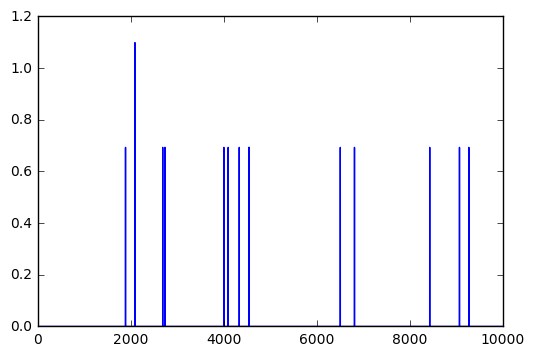

In [54]:
##representacion soft para TF ---mucho mejor!
X_train_input = np.log(X_train+1) 
X_val_input = np.log(X_val+1) 
X_test_input = np.log(X_test+1) 
plt.plot(X_train_input[0])
plt.show()

#soft para tf-idf
X_train_input2 = np.log(X_train2+1) 
X_val_input2 = np.log(X_val2+1) 
X_test_input2 = np.log(X_test2+1) 

In [83]:
hist1 = traditional_vae.fit(X_train_input, X_train, epochs=epochs, batch_size=batch_size
                           ,validation_data=(X_val_input,X_val))

Train on 5826 samples, validate on 1943 samples
Epoch 1/30
5826/5826 [==============================] - 2s - loss: 4900512.7499 - val_loss: 5179855.6112
Epoch 2/30
5826/5826 [==============================] - 0s - loss: 4894491.0173 - val_loss: 5176964.3598
Epoch 3/30
5826/5826 [==============================] - 0s - loss: 4886651.6156 - val_loss: 5176875.5947
Epoch 4/30
5826/5826 [==============================] - 0s - loss: 4878226.4909 - val_loss: 5182404.6081
Epoch 5/30
5826/5826 [==============================] - 0s - loss: 4873541.9092 - val_loss: 5183512.9972
Epoch 6/30
5826/5826 [==============================] - 1s - loss: 4870404.5173 - val_loss: 5179100.9189
Epoch 7/30
5826/5826 [==============================] - 0s - loss: 4862113.0414 - val_loss: 5182822.9879
Epoch 8/30
5826/5826 [==============================] - 1s - loss: 4860724.9436 - val_loss: 5187442.1683
Epoch 9/30
5826/5826 [==============================] - 1s - loss: 4861139.7921 - val_loss: 5192805.5885
Epoch 1

In [94]:
hist2 = binary_vae.fit(X_train_input, X_train, epochs=epochs, batch_size=batch_size
                           ,validation_data=(X_val_input,X_val))

Train on 8485 samples, validate on 2829 samples
Epoch 1/30
8485/8485 [==============================] - 3s - loss: 16897938.2994 - val_loss: 14964009.8795
Epoch 2/30
8485/8485 [==============================] - 1s - loss: 15200008.5716 - val_loss: 14556613.2340
Epoch 3/30
8485/8485 [==============================] - 1s - loss: 15014765.1833 - val_loss: 14481173.5196
Epoch 4/30
8485/8485 [==============================] - 1s - loss: 14982369.3530 - val_loss: 14481542.8575
Epoch 5/30
8485/8485 [==============================] - 1s - loss: 14974849.8863 - val_loss: 14473465.2167
Epoch 6/30
8485/8485 [==============================] - 1s - loss: 14964118.0542 - val_loss: 14476162.1905
Epoch 7/30
8485/8485 [==============================] - 1s - loss: 14952350.0124 - val_loss: 14456098.5281
Epoch 8/30
8485/8485 [==============================] - 1s - loss: 14933448.5557 - val_loss: 14439402.1262
Epoch 9/30
8485/8485 [==============================] - 1s - loss: 14915008.5763 - val_loss: 144

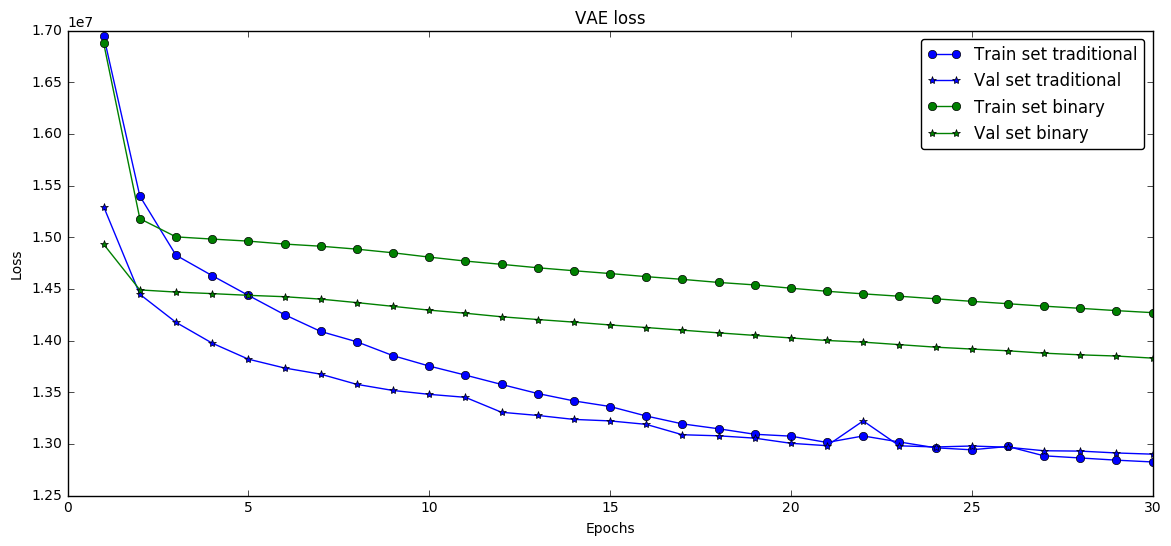

In [196]:
### binary vs traditional
history_dict1 = hist1.history
history_dict2 = hist2.history
loss_values1 = history_dict1['loss']
val_loss_values1 = history_dict1['val_loss']
loss_values2 = history_dict2['loss']
val_loss_values2 = history_dict2['val_loss']
epochs_l = range(1, len(loss_values1) + 1)

plt.figure(figsize=(14,6))
plt.plot(epochs_l, loss_values1, 'bo-', label = "Train set traditional")
plt.plot(epochs_l, val_loss_values1, 'b*-', label = "Val set traditional")
plt.plot(epochs_l, loss_values2, 'go-', label = "Train set binary")
plt.plot(epochs_l, val_loss_values2, 'g*-', label = "Val set binary")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="upper right", fancybox= True)
plt.title("VAE loss")
plt.show()

A través de las curvas de entrenamiento se puede ver que el vae tradicional le gana al binario en reconstrucción, lo cual resulta bastante lógico ya que tiene valores más libres en donde pueden vivir las variables (los reales) vs el binario que está mucho más restringido (entre 0 y 1). Otra cosa a nombrar es que el modelo con variables latentes binarias reduce el *overfitting* drásticamente, disminuyendo ambas curvas en la misma proporción.

### Results
---
Para evaluar los resultados y poder comparar es necesario realizar el proceso de evaluación en un sistema de recuperación de información. Ésto es recuperar objetos similares a los objetos de una consulta/*query*

#### Proceso de evaluación (*content-based retrieval*)
> *Query*: **Documento**

1. Calcular código hashing/binario de cada dato/documento
    * Para *VAE* tradicional se utiliza la mediana de cada componente (media) como *treshold*
    * Para *VAE* binario se utiliza el *treshold* de 0.5 en la probabilidad
2. Recuperar documentos basado en *match* perfecto, *top K* o *ball search* de distancia *hamming* de un documento consulta.
    * En el mismo conjunto/*set*
    * Con *query* recupero sobre *database*
3. Medir *precision* y *recall* en base a algún criterio de relevancia.
    * Documento relevante a otro o no -> Si comparten al menos una clase.

In [11]:
class MedianHashing(object):
    def __init__(self):
        self.threshold = None
        self.latent_dim = None
    def fit(self, X):
        self.threshold = np.median(X, axis=0)
        self.latent_dim = X.shape[1]
    def transform(self, X):
        assert(X.shape[1] == self.latent_dim)
        binary_code = np.zeros(X.shape)
        for i in range(self.latent_dim):
            binary_code[np.nonzero(X[:,i] < self.threshold[i]),i] = 0
            binary_code[np.nonzero(X[:,i] >= self.threshold[i]),i] = 1
        return binary_code.astype(int)
    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)
    
def get_similar(origen,destination,tipo="topK",K=100,ball=2):
    """
        Retrieve similar documents to the origen document inside the destination corpus (source)
    """
    origen_similares = [] #indices
    for number,dato_hash in enumerate(origen):
        hamming_distance = np.sum(dato_hash != destination,axis=1) #distancia de hamming (# bits distintos)
        if tipo=="EM": #match exacto
            ball= 0
        
        if tipo=="ball" or tipo=="EM":
            K = np.sum(np.sort(hamming_distance)<=ball)
            
        #get topK
        ordenados = np.argsort(hamming_distance) #indices
        origen_similares.append(ordenados[:K]) 
        
        origen_similares[-1] = np.setdiff1d(origen_similares[-1] , np.asarray(number))
    return origen_similares

#build similar or compared in labels
def measure_metrics(data_similars,labels_data,labels_destination=[]):
    #for now compare labels
    count_labels = {label:np.sum([label in aux for aux in labels_data]) for label in labels}
    precision = 0.
    recall =0.
    for similars, label in zip(data_similars,labels_data): #source de donde se extrajo info
        if len(similars) == 0: #no encontro similares:
            continue
            
        if len(labels_destination) == 0: #extrajo del mismo conjunto
            labels_retrieve = labels_data[similars] 
        else:
            labels_retrieve = labels_destination[similars] 
        
        if type(labels_retrieve[0]) == list: #multiple classes
            tp = np.sum([len(set(label)& set(aux))>=1 for aux in labels_retrieve]) #al menos 1 clase en comun --quizas variar
            recall += tp/np.sum([count_labels[aux] for aux in label ]) #cuenta todos los label del dato
        else: #only one class
            tp = np.sum(labels_retrieve == label) #true positive
            recall += tp/count_labels[label]
        precision += tp/len(similars)
    
    return precision/len(labels_data), recall/len(labels_data)

In [129]:
#load vae, encoder and generator
encode_train = encoder_Tvae.predict(X_train_input)
encode_val = encoder_Tvae.predict(X_val_input)

#para VAE tradicional
median= MedianHashing()
median.fit(encode_train)

train_hash = median.transform(encode_train)
val_hash = median.transform(encode_val)
train_hash

array([[1, 1, 1, ..., 0, 0, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 1, 1, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 1],
       [0, 1, 0, ..., 0, 0, 1],
       [1, 1, 1, ..., 1, 0, 0]])

In [119]:
encode_train = encoder_Bvae.predict(X_train_input) #logits
encode_val = encoder_Bvae.predict(X_val_input)

#para Binary VAE
probas_train = keras.activations.sigmoid(encode_train).eval(session=K.get_session())
probas_val = keras.activations.sigmoid(encode_val).eval(session=K.get_session())

train_hash = (probas_train > 0.5)*1
val_hash = (probas_val > 0.5)*1
train_hash

array([[1, 1, 0, ..., 0, 1, 1],
       [0, 0, 1, ..., 1, 1, 0],
       [1, 1, 1, ..., 0, 1, 0],
       ...,
       [0, 1, 0, ..., 0, 1, 1],
       [0, 1, 1, ..., 1, 1, 0],
       [1, 1, 1, ..., 0, 1, 1]])

In [79]:
val_similares_val =  get_similar(val_hash,val_hash,tipo="EM")
val_similares_val[:2]

[array([], dtype=int64), array([], dtype=int64)]

En algunos casos cuando se busca con un *match* exacto no se encuentra ningún otro dato que se le asigne la misma dirección, es por ésto que se acude a otras técnicas para buscar objetos similares.

In [137]:
val_similares_val =  get_similar(val_hash,val_hash,tipo="topK",K=100)
val_similares_val[:2]

[array([  18,   64,  124,  170,  185,  209,  212,  272,  277,  339,  352,
         399,  415,  425,  454,  459,  463,  467,  492,  498,  512,  517,
         518,  524,  603,  634,  648,  674,  744,  819,  832,  852,  865,
         869,  870,  972,  992, 1015, 1056, 1103, 1168, 1174, 1186, 1194,
        1200, 1237, 1247, 1277, 1323, 1339, 1367, 1402, 1411, 1463, 1473,
        1477, 1555, 1557, 1643, 1670, 1698, 1757, 1760, 1769, 1808, 1834,
        1835, 1849, 1856, 1968, 1991, 2033, 2074, 2078, 2095, 2116, 2129,
        2172, 2191, 2194, 2343, 2350, 2377, 2432, 2434, 2448, 2490, 2513,
        2538, 2563, 2564, 2625, 2661, 2740, 2774, 2776, 2794, 2795, 2822]),
 array([  45,   50,  103,  110,  147,  161,  169,  179,  187,  226,  274,
         287,  405,  426,  443,  535,  548,  597,  616,  641,  655,  776,
         785,  792,  835,  846,  873,  876,  890,  921,  973,  980, 1084,
        1136, 1155, 1219, 1222, 1315, 1322, 1337, 1340, 1346, 1354, 1357,
        1378, 1383, 1397, 1435, 1447

In [138]:
precision,recall = measure_metrics(val_similares_val,labels_val)
print("Precision (query: validation, source: validation) ",precision)
print("Recall    (query: validation, source: validation) ",recall)

Precision (query: validation, source: validation)  0.2675107383484876
Recall    (query: validation, source: validation)  0.18291936961539612


val_similares_train =  get_similar(val_hash,train_hash,tipo="topK",K=100)
#train_similares_train =  get_similar(train_hash,train_hash,tipo="ball",ball=2)
precision,recall = measure_metrics(val_similares_train,labels_val,labels_destination=labels_train)
print("Precision (query: val, source: train) ",precision)
print("Recall    (query: val, source: train) ",recall)

### Experimentación
---
A continación se realizan las experimentaciones correspondientes para encontrar la mejor arquitectura y mejor configuración del modelo propuesto en base a las métricas *precision* y *recall* del conjunto de validación en el **top 100** de elementos recuperados.

In [12]:
def evaluate_hashing(encoder,train,val,labels_set,traditional=True,tipo="topK"):
    encode_train = encoder.predict(train)
    encode_val = encoder.predict(val)
    if traditional:
        median= MedianHashing()
        median.fit(encode_train)
        val_hash = median.transform(encode_val)
    else: #para Binary VAE
        probas_val = keras.activations.sigmoid(encode_val).eval(session=K.get_session())
        val_hash = (probas_val > 0.5)*1

    val_similares_val =  get_similar(val_hash,val_hash,tipo=tipo,K=100) 
    return measure_metrics(val_similares_val,labels_set)

In [67]:
sin_lemma_traditional = {}
sin_lemma_binary = {}
    
traditional_vae,encoder_Tvae,generator_Tvae = traditional_VAE(X_train.shape[1],Nb=32,units=500,layers_e=2,layers_d=0)
traditional_vae.fit(X_train_input, X_train, epochs=epochs, batch_size=batch_size,verbose=0)
p1,r1 = evaluate_hashing(encoder_Tvae,X_train_input,X_val_input,labels_val,traditional=True)

traditional_vae,encoder_Tvae,generator_Tvae = traditional_VAE(X_train.shape[1],Nb=32,units=500,layers_e=2,layers_d=2)
traditional_vae.fit(X_train_input, X_train, epochs=epochs, batch_size=batch_size,verbose=0)
p2,r2 = evaluate_hashing(encoder_Tvae,X_train_input,X_val_input,labels_val,traditional=True)

sin_lemma_traditional["precision"] = [p1, p2] 
sin_lemma_traditional["recall"] = [r1, r2]

                    
binary_vae,encoder_Bvae,generator_Bvae = binary_VAE(X_train.shape[1],Nb=32,units=500,layers_e=2,layers_d=0)
binary_vae.fit(X_train_input, X_train, epochs=epochs, batch_size=batch_size,verbose=0)
p1,r1 = evaluate_hashing(encoder_Bvae,X_train_input,X_val_input,labels_val,traditional=False)

binary_vae,encoder_Bvae,generator_Bvae = binary_VAE(X_train.shape[1],Nb=32,units=500,layers_e=2,layers_d=2)
binary_vae.fit(X_train_input, X_train, epochs=epochs, batch_size=batch_size,verbose=0)
p2,r2 = evaluate_hashing(encoder_Bvae,X_train_input,X_val_input,labels_val,traditional=False)

sin_lemma_binary["precision"] = [p1, p2] 
sin_lemma_binary["recall"] = [r1, r2]
print("Terminó")

pre-encoder network:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_34 (Dense)             (None, 500)               5000500   
_________________________________________________________________
batch_normalization_23 (Batc (None, 500)               2000      
_________________________________________________________________
dense_35 (Dense)             (None, 500)               250500    
_________________________________________________________________
batch_normalization_24 (Batc (None, 500)               2000      
Total params: 5,255,000
Trainable params: 5,253,000
Non-trainable params: 2,000
_________________________________________________________________
generator network:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 10000)             330000    
Total params: 330,000


In [231]:
con_lemma_traditional = {}
con_lemma_binary = {}
    
traditional_vae,encoder_Tvae,generator_Tvae = traditional_VAE(X_train.shape[1],Nb=32,units=500,layers_e=2,layers_d=0)
traditional_vae.fit(X_train_input, X_train, epochs=epochs, batch_size=batch_size,verbose=0)
p1,r1 = evaluate_hashing(encoder_Tvae,X_train_input,X_val_input,labels_val,traditional=True)

traditional_vae,encoder_Tvae,generator_Tvae = traditional_VAE(X_train.shape[1],Nb=32,units=500,layers_e=2,layers_d=2)
traditional_vae.fit(X_train_input, X_train, epochs=epochs, batch_size=batch_size,verbose=0)
p2,r2 = evaluate_hashing(encoder_Tvae,X_train_input,X_val_input,labels_val,traditional=True)

con_lemma_traditional["precision"] = [p1, p2] 
con_lemma_traditional["recall"] = [r1, r2]

binary_vae,encoder_Bvae,generator_Bvae = binary_VAE(X_train.shape[1],Nb=32,units=500,layers_e=2,layers_d=0)
binary_vae.fit(X_train_input, X_train, epochs=epochs, batch_size=batch_size,verbose=0)
p1,r1 = evaluate_hashing(encoder_Bvae,X_train_input,X_val_input,labels_val,traditional=False)

binary_vae,encoder_Bvae,generator_Bvae = binary_VAE(X_train.shape[1],Nb=32,units=500,layers_e=2,layers_d=2)
binary_vae.fit(X_train_input, X_train, epochs=epochs, batch_size=batch_size,verbose=0)
p2,r2 = evaluate_hashing(encoder_Bvae,X_train_input,X_val_input,labels_val,traditional=False)

con_lemma_binary["precision"] = [p1, p2] 
con_lemma_binary["recall"] = [r1, r2]
print("Terminó")

pre-encoder network:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_121 (InputLayer)       (None, 10000)             0         
_________________________________________________________________
dense_121 (Dense)            (None, 500)               5000500   
_________________________________________________________________
batch_normalization_73 (Batc (None, 500)               2000      
_________________________________________________________________
dense_122 (Dense)            (None, 500)               250500    
_________________________________________________________________
batch_normalization_74 (Batc (None, 500)               2000      
Total params: 5,255,000
Trainable params: 5,253,000
Non-trainable params: 2,000
_________________________________________________________________
generator network:
_________________________________________________________________
Layer (type)          

### Resultados en 20newsgroup

In [106]:
print("Resultados de Precision en validación")

t = Table()
t[""] = ["Base", "Simetrico"]
t["Sin Lemma"] = sin_lemma_traditional["precision"]
t["Con Lemma"] = con_lemma_traditional["precision"]
print("\n*** VAE Traditional***")
print(t)

t = Table()
t[""] = ["Base", "Simetrico"]
t["Sin Lemma"] = sin_lemma_binary["precision"]
t["Con Lemma"] = con_lemma_binary["precision"]
print("\n*** VAE Binary***")
print(t)

Resultados de Precision en validación

*** VAE Traditional***
               Sin Lemma           Con Lemma     
--------- ------------------- -------------------
     Base  0.2798540370120401  0.2841565174544985
Simetrico 0.22855275983589507 0.27704046473929445

*** VAE Binary***
               Sin Lemma           Con Lemma     
--------- ------------------- -------------------
     Base 0.27538017145651994 0.31629122615336525
Simetrico   0.339728140364405   0.352853383606297


In [107]:
print("Resultados de Recall en validación")

t = Table()
t[""] = ["Base", "Simetrico"]
t["Sin Lemma"] = sin_lemma_traditional["recall"]
t["Con Lemma"] = con_lemma_traditional["recall"]
print("\n*** VAE Traditional***")
print(t)

t = Table()
t[""] = ["Base", "Simetrico"]
t["Sin Lemma"] = sin_lemma_binary["recall"]
t["Con Lemma"] = con_lemma_binary["recall"]
print("\n*** VAE Binary***")
print(t)

Resultados de Recall en validación

*** VAE Traditional***
               Sin Lemma          Con Lemma     
--------- ------------------- ------------------
     Base 0.19157503942601106 0.1935634800277119
Simetrico  0.1567055109236688 0.1890441069169437

*** VAE Binary***
               Sin Lemma           Con Lemma     
--------- ------------------- -------------------
     Base  0.1867768042416021 0.21653550976898298
Simetrico 0.23209726149925983 0.24124950620939722


En base a la experimentación anterior se encuentra con que aplicar *Lemmatization* a los *tokens* conlleva una mejora en ambas métricas (*precision* y *recall*), además de que utilizar una arquitectura simétrica (a pesar del incremento considerable de parámetros) conlleva una gran mejora en el *VAE* Binario, mientras que la arquitectura base (no simétrica) es mejor para el *VAE* tradicional.

### Experimentando con *TF* vs *TF-IDF*

In [13]:
traditional_dat = {"20news":{"p":[],"r":[]},"snippets":{"p":[],"r":[]},"reuters":{"p":[],"r":[]}}
binary_dat = {"20news":{"p":[],"r":[]},"snippets":{"p":[],"r":[]},"reuters":{"p":[],"r":[]}}

In [43]:
dataset = "snippets"
#TF
traditional_vae,encoder_Tvae,generator_Tvae = traditional_VAE(X_train.shape[1],Nb=32,units=500,layers_e=2,layers_d=0)
traditional_vae.fit(X_train_input, X_train, epochs=epochs, batch_size=batch_size,verbose=0)
p_t,r_t = evaluate_hashing(encoder_Tvae,X_train_input,X_val_input,labels_val,traditional=True)
traditional_dat[dataset]["p"].append(p_t) 
traditional_dat[dataset]["r"].append(r_t) 

#IDF
traditional_vae,encoder_Tvae,generator_Tvae = traditional_VAE(X_train.shape[1],Nb=32,units=500,layers_e=2,layers_d=0)
traditional_vae.fit(X_train_input2, X_train, epochs=epochs, batch_size=batch_size,verbose=0)
p_t,r_t = evaluate_hashing(encoder_Tvae,X_train_input2,X_val_input2,labels_val,traditional=True)
traditional_dat[dataset]["p"].append(p_t) 
traditional_dat[dataset]["r"].append(r_t) 

#TF
binary_vae,encoder_Bvae,generator_Bvae = binary_VAE(X_train.shape[1],Nb=32,units=500,layers_e=2,layers_d=2)
binary_vae.fit(X_train_input, X_train, epochs=epochs, batch_size=batch_size,verbose=0)
p_b,r_b = evaluate_hashing(encoder_Bvae,X_train_input,X_val_input,labels_val,traditional=False)
binary_dat[dataset]["p"].append(p_b) 
binary_dat[dataset]["r"].append(r_b) 

#IDF
binary_vae,encoder_Bvae,generator_Bvae = binary_VAE(X_train.shape[1],Nb=32,units=500,layers_e=2,layers_d=2)
binary_vae.fit(X_train_input2, X_train, epochs=epochs, batch_size=batch_size,verbose=0)
p_b,r_b = evaluate_hashing(encoder_Bvae,X_train_input2,X_val_input2,labels_val,traditional=False)
binary_dat[dataset]["p"].append(p_b) 
binary_dat[dataset]["r"].append(r_b)

print("Terminó")

pre-encoder network:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_43 (InputLayer)        (None, 10000)             0         
_________________________________________________________________
dense_51 (Dense)             (None, 500)               5000500   
_________________________________________________________________
batch_normalization_37 (Batc (None, 500)               2000      
_________________________________________________________________
dense_52 (Dense)             (None, 500)               250500    
_________________________________________________________________
batch_normalization_38 (Batc (None, 500)               2000      
Total params: 5,255,000
Trainable params: 5,253,000
Non-trainable params: 2,000
_________________________________________________________________
generator network:
_________________________________________________________________
Layer (type)          

In [44]:
print("Resultados de Precision en validación")
t = Table()
t[""] = ["TF", "TF-IDF"]
t["20News"] = traditional_dat["20news"]["p"]
t["Reuters"] = traditional_dat["reuters"]["p"]
t["Snippets"] = traditional_dat["snippets"]["p"]
print("\n*** VAE Traditional***")
print(t)
t = Table()
t[""] = ["TF", "TF-IDF"]
t["20News"] = binary_dat["20news"]["p"]
t["Reuters"] = binary_dat["reuters"]["p"]
t["Snippets"] = binary_dat["snippets"]["p"]
print("\n*** VAE Binary***")
print(t)

Resultados de Precision en validación

*** VAE Traditional***
             20News            Reuters            Snippets     
------ ------------------ ------------------ ------------------
    TF 0.2688639666370281 0.4987653165728302 0.3486394762736693
TF-IDF 0.2852241038879395 0.5083412613006016 0.3340843825933263

*** VAE Binary***
              20News            Reuters             Snippets     
------ ------------------- ------------------ -------------------
    TF 0.35401737416583284 0.5997962122511791  0.4200052211980623
TF-IDF  0.3618618136115463  0.599744225580561 0.41140630961704383


In [45]:
print("Resultados de Recall en validación")
t = Table()
t[""] = ["TF", "TF-IDF"]
t["20News"] = traditional_dat["20news"]["r"]
t["Reuters"] = traditional_dat["reuters"]["r"]
t["Snippets"] = traditional_dat["snippets"]["r"]
print("\n*** VAE Traditional***")
print(t)
t = Table()
t[""] = ["TF", "TF-IDF"]
t["20News"] = binary_dat["20news"]["r"]
t["Reuters"] = binary_dat["reuters"]["r"]
t["Snippets"] = binary_dat["snippets"]["r"]
print("\n*** VAE Binary***")
print(t)

Resultados de Recall en validación

*** VAE Traditional***
              20News             Reuters             Snippets     
------ ------------------- ------------------- -------------------
    TF 0.18454084740966342 0.18395508938895405 0.09803543536505138
TF-IDF 0.19430150271819863 0.18221513247670762 0.09385609805437488

*** VAE Binary***
              20News             Reuters             Snippets     
------ ------------------- ------------------- -------------------
    TF   0.241946459609219 0.23288717284653163 0.11986004136790665
TF-IDF 0.24730287141004545 0.22389574207186788 0.11696040080518362


Se puede observar que las variaciones respecto a la representación resultan en cambios bastante leves, donde en algunos casos es mejor *TF* mientras que en otros es mejor *TF-IDF*. Respecto a los datasets se puede ver que los mejores resultados se encuentran en el dataset de **Reuters**, posiblemente gracias a que su estructura de que un texto puede hablar de varios temas a la vez y no de uno solo, mientras que el peor en *precision* se encuentra en **20Newsgroup**, debido a que los textos, a pesar de pertenecer a diferentes clases, al parecer hablan de temas similares entre sí lo cual resulta que el modelo le cueste proyectar los documentos a una única región de direcciones de memorias que correspondan a una clase, ya que posiblemente los patrones entre algunas clases resultan similares entre sí. Mientras que el peor en *recall* se obtiene en el dataset de **Snippets**, posiblemente por falta de generalización en ese conjunto y que los textos de una cierta clase/dominio sea muy general por lo que los textos dentro de cada dominio podrían tener características muy distintas entre sí, lo cual hace difícil encontrar patrones similares que hagan proyectarlos a todos los de una misma clase en regiones cercanas.

### Experimentando con variar #Bits
Ahora se experimentará variando el número de *bits* en la proyeción, utilizando la representación de *Term frequency*

In [54]:
traditional_dat = {"20news":{"p":[],"r":[]},"snippets":{"p":[],"r":[]},"reuters":{"p":[],"r":[]}}
binary_dat = {"20news":{"p":[],"r":[]},"snippets":{"p":[],"r":[]},"reuters":{"p":[],"r":[]}}

In [72]:
dataset = "reuters"

for Nbits in [16,32,64]:
    #TF
    traditional_vae,encoder_Tvae,generator_Tvae = traditional_VAE(X_train.shape[1],Nb=Nbits,units=500,layers_e=2,layers_d=0)
    traditional_vae.fit(X_train_input, X_train, epochs=epochs, batch_size=batch_size,verbose=0)
    p_t,r_t = evaluate_hashing(encoder_Tvae,X_train_input,X_val_input,labels_val,traditional=True)
    traditional_dat[dataset]["p"].append(p_t) 
    traditional_dat[dataset]["r"].append(r_t) 
    #TF
    binary_vae,encoder_Bvae,generator_Bvae = binary_VAE(X_train.shape[1],Nb=Nbits,units=500,layers_e=2,layers_d=2)
    binary_vae.fit(X_train_input, X_train, epochs=epochs, batch_size=batch_size,verbose=0)
    p_b,r_b = evaluate_hashing(encoder_Bvae,X_train_input,X_val_input,labels_val,traditional=False)
    binary_dat[dataset]["p"].append(p_b) 
    binary_dat[dataset]["r"].append(r_b) 
print("Terminó")

pre-encoder network:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_127 (InputLayer)       (None, 10000)             0         
_________________________________________________________________
dense_163 (Dense)            (None, 500)               5000500   
_________________________________________________________________
batch_normalization_121 (Bat (None, 500)               2000      
_________________________________________________________________
dense_164 (Dense)            (None, 500)               250500    
_________________________________________________________________
batch_normalization_122 (Bat (None, 500)               2000      
Total params: 5,255,000
Trainable params: 5,253,000
Non-trainable params: 2,000
_________________________________________________________________
generator network:
_________________________________________________________________
Layer (type)          

In [136]:
print("Resultados de Precision en validación")
t = Table()
t["Bits"] = [16, 32,64]
t["20News"] = traditional_dat["20news"]["p"]
t["Reuters"] = traditional_dat["reuters"]["p"]
t["Snippets"] = traditional_dat["snippets"]["p"]
print("\n*** VAE Traditional***")
print(t)
t = Table()
t["Bits"] = [16, 32,64]
t["20News"] = binary_dat["20news"]["p"]
t["Reuters"] = binary_dat["reuters"]["p"]
t["Snippets"] = binary_dat["snippets"]["p"]
print("\n*** VAE Binary***")
print(t)

print("\n\n\nResultados de Recall en validación")
t = Table()
t["Bits"] = [16, 32,64]
t["20News"] = traditional_dat["20news"]["r"]
t["Reuters"] = traditional_dat["reuters"]["r"]
t["Snippets"] = traditional_dat["snippets"]["r"]
print("\n*** VAE Traditional***")
print(t)
t = Table()
t["Bits"] = [16, 32,64]
t["20News"] = binary_dat["20news"]["r"]
t["Reuters"] = binary_dat["reuters"]["r"]
t["Snippets"] = binary_dat["snippets"]["r"]
print("\n*** VAE Binary***")
print(t)

Resultados de Precision en validación

*** VAE Traditional***
Bits        20News            Reuters             Snippets     
---- ------------------- ------------------ -------------------
  16 0.27083132491403583 0.5125573802876942  0.3570174910135129
  32 0.27802235861620467 0.5117047988895648  0.3436994196437515
  64  0.2696244880762342 0.5186398207499591 0.37064883426712203

*** VAE Binary***
Bits        20News            Reuters             Snippets     
---- ------------------- ------------------ -------------------
  16 0.32097575257702177  0.577603102564503  0.4039761431411513
  32 0.36601433208007667 0.5974672094075084   0.427897262887322
  64 0.37677588897100944 0.6063257380807564 0.42422635901761013



Resultados de Recall en validación

*** VAE Traditional***
Bits        20News             Reuters             Snippets     
---- ------------------- ------------------- -------------------
  16 0.18627945250057718 0.18200302542455954 0.10011212451815474
  32 0.189676217528682

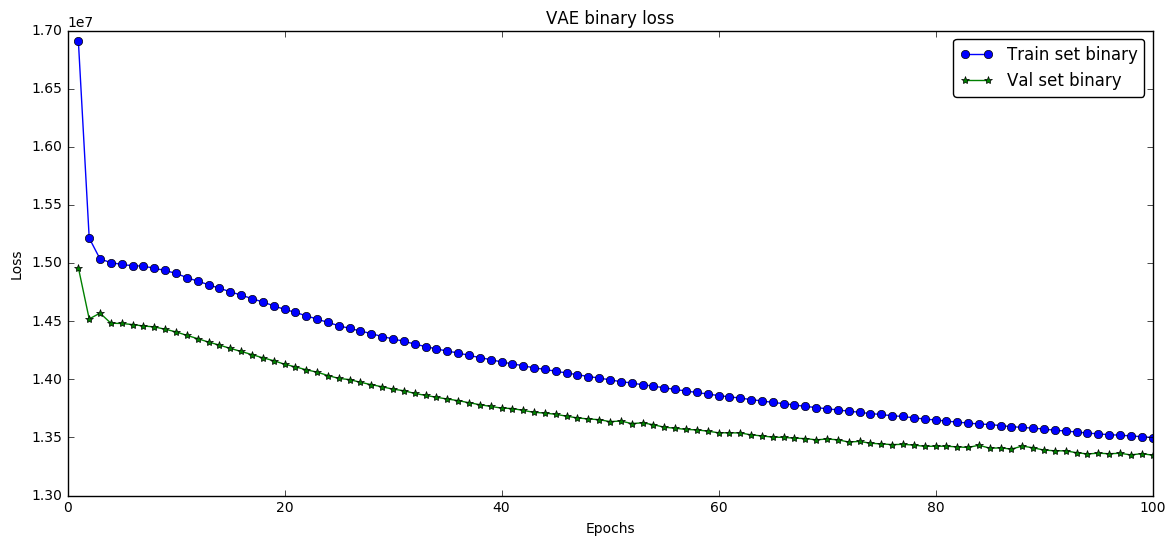

Valor anterior de precision:  0.35
Precision con epoch= 100 0.37125228959799317


In [126]:
##aumentar los epochs mejora?? --> si!
history_dict2 = hist2.history
loss_values2 = history_dict2['loss']
val_loss_values2 = history_dict2['val_loss']
epochs_l = range(1, len(loss_values2) + 1)

plt.figure(figsize=(14,6))
plt.plot(epochs_l, loss_values2, 'bo-', label = "Train set binary")
plt.plot(epochs_l, val_loss_values2, 'g*-', label = "Val set binary")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="upper right", fancybox= True)
plt.title("VAE binary loss")
plt.show()

print("Valor anterior de precision: ",0.35)
print("Precision con epoch= 100",precision)

## *Best models facing test set*
Luego de la selección de la mejor configuración de los modelos se evalua de diferentes formas sobre el conjunto de pruebas de los distintos *datasets*, los cambios realizados son:
* Se entrenan sobre todos los datos disponibles (*train+val*)
* Se aumentó el número de *epochs* a 50.

El mejor modelo:
* Simétrica para *Binary VAE* y Base para *Traditional VAE*
* 32 Bits en la codificación (número de variables latentes)
* Representación sobre las top 10 mil palabras y *Term Frequency*

In [16]:
def evaluate_hashing(encoder,train,test,labels_trainn,labels_testt,traditional=True,tipo="topK"):
    """
        Evaluate Hashing correclty: Query and retrieve on a different set
    """
    encode_train = encoder.predict(train)
    encode_test = encoder.predict(test)
    if traditional:
        median= MedianHashing()
        median.fit(encode_train)
        
        train_hash = median.transform(encode_train)
        test_hash = median.transform(encode_test)
    else: #para Binary VAE
        probas_train = keras.activations.sigmoid(encode_train).eval(session=K.get_session())
        probas_test = keras.activations.sigmoid(encode_test).eval(session=K.get_session())
        
        train_hash = (probas_train > 0.5)*1
        test_hash = (probas_test > 0.5)*1

    test_similares_train =  get_similar(test_hash,train_hash,tipo="topK",K=100)
    return measure_metrics(test_similares_train,labels_testt,labels_destination=labels_trainn)

#to save results
results_dat = {"20news":{"p":[],"r":[]},"snippets":{"p":[],"r":[]},"reuters":{"p":[],"r":[]}} #for topk
traditional_dat = {"20news":{"p":[],"r":[]},"snippets":{"p":[],"r":[]},"reuters":{"p":[],"r":[]}} #for ball radius
binary_dat = {"20news":{"p":[],"r":[]},"snippets":{"p":[],"r":[]},"reuters":{"p":[],"r":[]}} #for ball radius

In [55]:
X_total_input = np.concatenate((X_train_input,X_val_input),axis=0)
X_total = np.concatenate((X_train,X_val),axis=0)
labels_total = np.concatenate((labels_train,labels_val),axis=0)

traditional_vae,encoder_Tvae,generator_Tvae = traditional_VAE(X_train.shape[1],Nb=32,units=500,layers_e=2,layers_d=0)
traditional_vae.fit(X_total_input, X_total, epochs=50, batch_size=batch_size,verbose=0)

binary_vae,encoder_Bvae,generator_Bvae = binary_VAE(X_train.shape[1],Nb=32,units=500,layers_e=2,layers_d=2)
binary_vae.fit(X_total_input, X_total, epochs=50, batch_size=batch_size,verbose=0)

pre-encoder network:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        (None, 10000)             0         
_________________________________________________________________
dense_26 (Dense)             (None, 500)               5000500   
_________________________________________________________________
batch_normalization_19 (Batc (None, 500)               2000      
_________________________________________________________________
dense_27 (Dense)             (None, 500)               250500    
_________________________________________________________________
batch_normalization_20 (Batc (None, 500)               2000      
Total params: 5,255,000
Trainable params: 5,253,000
Non-trainable params: 2,000
_________________________________________________________________
generator network:
_________________________________________________________________
Layer (type)          

In [56]:
dataset = "snippets"

p_t,r_t = evaluate_hashing(encoder_Tvae,X_total_input,X_test_input,labels_total,labels_test,traditional=True,tipo="topK")
results_dat[dataset]["p"].append(p_t)
results_dat[dataset]["r"].append(r_t)

p_b,r_b = evaluate_hashing(encoder_Bvae,X_total_input,X_test_input,labels_total,labels_test,traditional=False,tipo="topK")
results_dat[dataset]["p"].append(p_b)
results_dat[dataset]["r"].append(r_b)
print("Realizado.")

Realizado.


In [57]:
%%time
ball_radius = np.arange(0,10) #ball of radius graphic

binary_p = []
binary_r = []
encode_total = encoder_Bvae.predict(X_total_input)
encode_test = encoder_Bvae.predict(X_test_input)
probas_total= keras.activations.sigmoid(encode_total).eval(session=K.get_session())
probas_test= keras.activations.sigmoid(encode_test).eval(session=K.get_session())
total_hash_b = (probas_total > 0.5)*1
test_hash_b = (probas_test > 0.5)*1
    
traditional_p = []
traditional_r = []
encode_total = encoder_Tvae.predict(X_total_input)
encode_test = encoder_Tvae.predict(X_test_input)
median= MedianHashing()
median.fit(encode_total)
total_hash_t = median.transform(encode_total)
test_hash_t = median.transform(encode_test)


for ball_r in ball_radius:
    test_similares_train =  get_similar(test_hash_b,total_hash_b,tipo='ball',ball=ball_r) 
    p_b,r_b  = measure_metrics(test_similares_train,labels_test,labels_destination=labels_total)
    binary_dat[dataset]["p"].append(p_b)
    binary_dat[dataset]["r"].append(r_b)
    
    test_similares_train =  get_similar(test_hash_t,total_hash_t,tipo='ball',ball=ball_r) 
    p_t,r_t  = measure_metrics(test_similares_train,labels_test,labels_destination=labels_total)
    traditional_dat[dataset]["p"].append(p_t)
    traditional_dat[dataset]["r"].append(r_t)

print("Termino")

Termino
CPU times: user 40.5 s, sys: 318 ms, total: 40.9 s
Wall time: 39.4 s


In [62]:
print("*************Top 100 most similar retrieve*************")

print("\nResultados de Precision en pruebas")
t = Table()
t["Modelo"] = ["Tradicional","Binario"]
t["20News"] = results_dat["20news"]["p"]
t["Reuters"] = results_dat["reuters"]["p"]
t["Snippets"] = results_dat["snippets"]["p"]
print(t)

print("\n\nResultados de Recall en pruebas")
t = Table()
t["Modelo"] = ["Tradicional","Binario"]
t["20News"] = results_dat["20news"]["r"]
t["Reuters"] = results_dat["reuters"]["r"]
t["Snippets"] = results_dat["snippets"]["r"]
print(t)

*************Top 100 most similar retrieve*************

Resultados de Precision en pruebas
   Modelo         20News            Reuters             Snippets     
----------- ------------------ ------------------ -------------------
Tradicional 0.3198431607632358 0.5555632174678232 0.29661540847067136
    Binario 0.4412580934142276 0.6978235150444521  0.3812511961722483


Resultados de Recall en pruebas
   Modelo          20News             Reuters             Snippets     
----------- ------------------- ------------------- -------------------
Tradicional 0.08368164628228804 0.17358614696801034  0.0989468367889419
    Binario 0.11571856965491284 0.24586105087136056 0.12721012759170613


### Experimentos con el *ball search*
A continuación se muestra una leve experimentación cuando se trabaja con la búsqueda a través de un radio en el espacio de *Haming*.

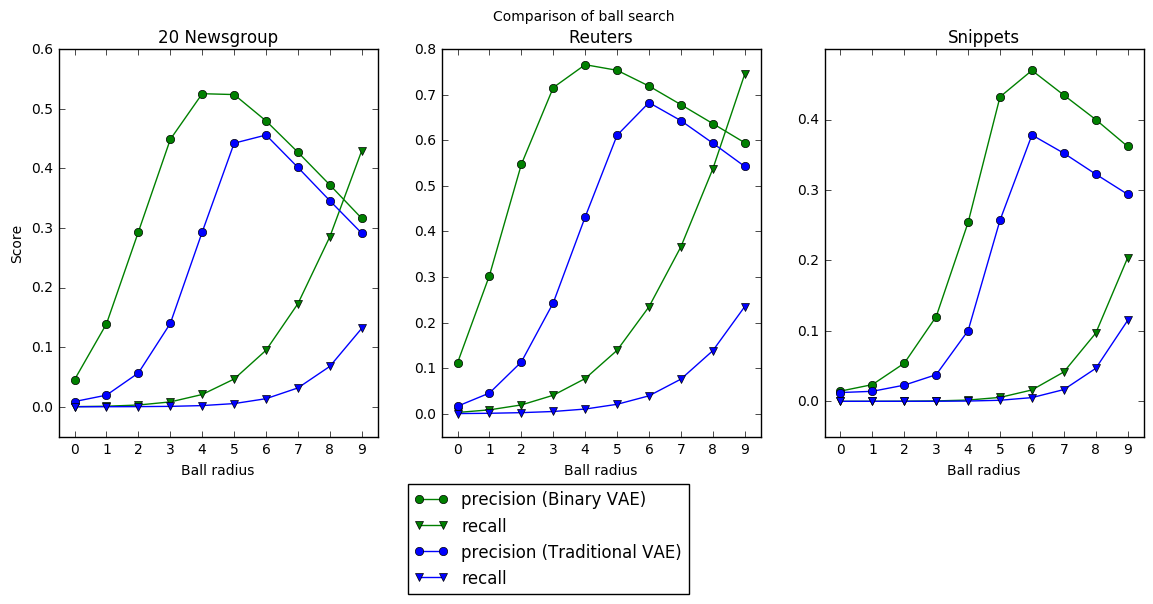

In [79]:
f, axx = plt.subplots(1,3, figsize=(14,5))

axx[0].plot(ball_radius,binary_dat["20news"]["p"],'go-',label="precision (Binary VAE)")
axx[0].plot(ball_radius,binary_dat["20news"]["r"],'gv-', label='recall' ) 
axx[0].plot(ball_radius,traditional_dat["20news"]["p"],'bo-',label="precision (Traditional VAE)")
axx[0].plot(ball_radius,traditional_dat["20news"]["r"],'bv-', label='recall' ) 
axx[0].set_ylabel("Score")
axx[0].set_title("20 Newsgroup")
axx[0].legend(bbox_to_anchor=(2, -0.1))

axx[1].plot(ball_radius,binary_dat["reuters"]["p"],'go-')
axx[1].plot(ball_radius,binary_dat["reuters"]["r"],'gv-' ) 
axx[1].plot(ball_radius,traditional_dat["reuters"]["p"],'bo-')
axx[1].plot(ball_radius,traditional_dat["reuters"]["r"],'bv-' ) 
axx[1].set_title("Reuters")

axx[2].plot(ball_radius,binary_dat["snippets"]["p"],'go-')
axx[2].plot(ball_radius,binary_dat["snippets"]["r"],'gv-') 
axx[2].plot(ball_radius,traditional_dat["snippets"]["p"],'bo-')
axx[2].plot(ball_radius,traditional_dat["snippets"]["r"],'bv-') 
axx[2].set_title("Snippets")

for i in range(3):
    axx[i].set_xticks(ball_radius)
    axx[i].set_xlabel("Ball radius")
    axx[i].set_xlim(-0.5,9.5)
    axx[i].set_ylim(-0.05)
    
f.suptitle("Comparison of ball search")
plt.show()

### Analysis
---
Intepretar los códigos binarios en cada dataset

In [20]:
def get_topk_probably_words(probabilities,K):
    order_vocabulary =  np.argsort(probabilities) 
    tokens_probables = order_vocabulary[:K]  #token mas probables
    return list(map(lambda x:idx2token[x] ,tokens_probables))

##valores unicos de hash? distribucion de casillas
def hash_analysis(hash_data):
    hash_string = []
    for valor in hash_data:
        hash_string.append(str(valor)[1:-1].replace(' ',''))
    valores_unicos = set(hash_string)
    count_hash = {valor: hash_string.count(valor) for valor in valores_unicos}
    return valores_unicos, count_hash


In [58]:
encode_train = encoder_Bvae.predict(X_total_input) #logits
Nb = encode_train.shape[1]

#para Binary VAE
probas_train = keras.activations.sigmoid(encode_train).eval(session=K.get_session())
train_hash = (probas_train > 0.5)*1

Cantidad de memorias en tabla hash:  4294967296
Entrenamiento----
Cantidad de datos a llenar la tabla hash:  8485


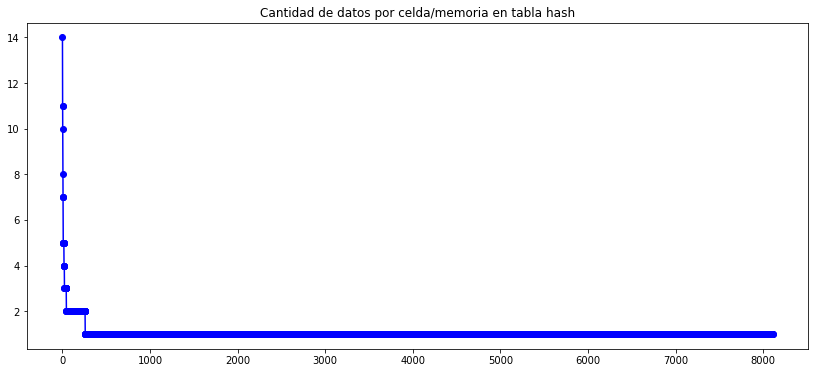

Cantidad de memorias ocupadas:  8108
Validación-----
Cantidad de datos a llenar la tabla hash:  2829


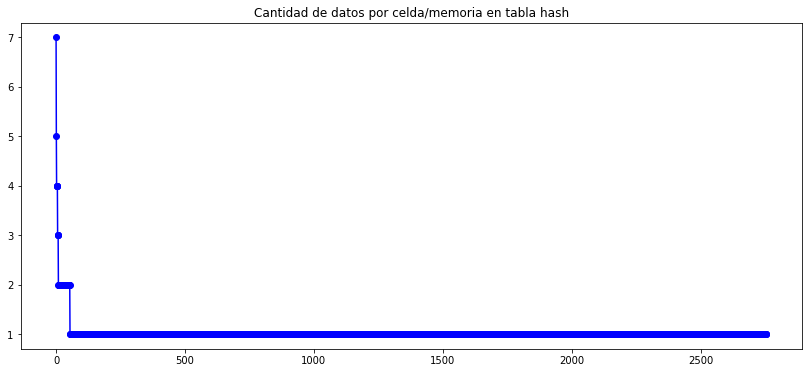

Cantidad de memorias ocupadas:  2756


In [20]:
print("Cantidad de memorias en tabla hash: ",2**train_hash.shape[1])

valores_unicos, count_hash =  hash_analysis(train_hash)
print("Entrenamiento----")
print("Cantidad de datos a llenar la tabla hash: ",train_hash.shape[0])
plt.figure(figsize=(14,6))
plt.plot(sorted(list(count_hash.values()))[::-1],'bo-')
plt.title("Cantidad de datos por celda/memoria en tabla hash")
plt.show()
print("Cantidad de memorias ocupadas: ",len(valores_unicos))

valores_unicos, count_hash =  hash_analysis(val_hash)
print("Validación-----")
print("Cantidad de datos a llenar la tabla hash: ",val_hash.shape[0])
plt.figure(figsize=(14,6))
plt.plot(sorted(list(count_hash.values()))[::-1],'bo-')
plt.title("Cantidad de datos por celda/memoria en tabla hash")
plt.show()
print("Cantidad de memorias ocupadas: ",len(valores_unicos))

se ocupan varias celdas de memorias gracias a la restricción de las variables latentes en el VAE

#generar un dato

#----- dada una probabilidad sobre el codigo
proba_b = np.random.rand(2,Nb).astype('float32')


def sampling(aux):
    logits_b = K.log(aux/(1-aux) + K.epsilon() )
    b = logits_b + sample_gumbel(K.shape(logits_b)) # logits + gumbel noise
    return keras.activations.sigmoid( b/0.5 )
b = sampling(proba_b).eval(session=K.get_session())

reconstruct_data = generator_Bvae.predict(b)
reconstruct_data

In [22]:
#iterar sobre el resto de los bits y ver sus palabras mas frecuentes
def show_probable_words(topKwords,samplebits):
    probable_words = []
    for i in range(Nb):
        b = np.zeros((1,Nb))
        b[0,i] = 1 #solo un bit con uno

        reconstruct_data = generator_Bvae.predict(b)
        probable_words.append(get_topk_probably_words(reconstruct_data[0],K=topKwords))
    
    bits = np.random.choice(np.arange(Nb),samplebits,replace=False)
    t = Table()
    for b in bits:
        t["bit "+ str(b)] = probable_words[b]
    return t

In [26]:
print("20 Newsgroup")
show_probable_words(12,8)

20 Newsgroup


bit 22,bit 13,bit 5,bit 14,bit 29,bit 9,bit 30,bit 18
str12,str7,str12,str12,str13,str13,str13,str13
mimsy,megatek,rigorous,invitation,rigorous,complexity,heterosexual,newman
hopper,lbl,complexity,inconsistent,governing,heterosexual,invitation,likelihood
newman,newman,hubble,ehrlich,p00261,likelihood,pythagorean,slac
complexity,acme,mimsy,lbl,ebay,inconsistent,preservation,bernard
heterosexual,grief,likelihood,asia,eager,lbl,dani,rigorous
slac,ccc,inconsistent,kou,bernard,skeptic,harassment,sax
lbl,amdahl,finite,newman,inaccurate,presidential,homosexuality,dsi
dani,fuer,sl2,guidance,misunderstand,prohibits,lbl,introductory
hubble,rusnews,refutation,jhuapl,dishonest,homosexuality,asia,ranting


In [46]:
print("Reuters")
show_probable_words(12,8)

Reuters


bit 9,bit 31,bit 21,bit 7,bit 14,bit 29,bit 5,bit 17
str11,str14,str12,str12,str12,str10,str14,str11
danger,device,eed,printing,murray,toronto,responsibility,printing
object,recognize,consummated,ica,hindered,receivable,weakening,analyze
consummated,responsibility,analyze,elmd,baby,catalyst,recognize,device
relate,analyze,recognize,projecting,accurate,murray,analyze,dallas
hostile,printing,moines,analyze,proceeding,stretch,edition,catalyst
weakening,undoubtedly,cancellation,baby,justify,printing,colo,exploring
cellular,describing,severance,kpk,master,analyze,sierra,proof
printing,existence,colo,device,uneconomic,projecting,eighth,elmd
uneconomic,projecting,defensive,undoubtedly,jacksonville,edmonton,mature,object


In [61]:
print("Snippets")
show_probable_words(12,8)

Snippets


bit 29,bit 25,bit 0,bit 30,bit 15,bit 24,bit 19,bit 4
str12,str14,str12,str12,str12,str13,str12,str12
interaction,interaction,biogeography,emc,chamber,managing,gymnastics,biogeography
biogeography,biogeography,interactive,investor,agency,biogeography,chamber,emc
gymnastics,composer,composer,biogeography,patient,emc,biogeography,gymnastics
requirement,radiology,gymnastics,requirement,biogeography,ecology,cam,interaction
specializes,gymnastics,chamber,unl,emc,visualization,healthcare,beginner
logo,patient,campus,chamber,cdc,lighting,focusing,consisting
consisting,seattle,ballet,ecology,specializes,cable,cdc,newsday
butler,creative,lesson,interaction,composer,credible,flat,unl
emc,ballet,requirement,beginner,drama,interaction,interactive,historic


### Referencias
---
[1] Salakhutdinov, R., & Hinton, G. (2009). *Semantic hashing*. International Journal of Approximate Reasoning, 50(7), 969-978.  
[2] Chaidaroon, S., & Fang, Y. (2017, August). *Variational deep semantic hashing for text documents*. In Proceedings of the 40th International ACM SIGIR Conference on Research and Development in Information Retrieval (pp. 75-84). ACM.  
[3] Chaidaroon, S., Ebesu, T., & Fang, Y. (2018). *Deep Semantic Text Hashing with Weak Supervision*. SIGIR.  
[4] Maddison, C. J., Mnih, A., & Teh, Y. W. (2016). The concrete distribution: A continuous relaxation of discrete random variables. arXiv preprint arXiv:1611.00712.  
[5] Jang, E., Gu, S., & Poole, B. (2016). *Categorical reparameterization with gumbel-softmax*. arXiv preprint arXiv:1611.01144.